# Deep Q-learning (DQN)

This notebook describes the DQN reinforcement learning (RL) algorithm.


## Environment

We will train an agent to balance a vertical pole on a cart. This is a classic environment in RL, named CartPole. See the environment description [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to get more details about the environment.

In [1]:
# Library imports
import gymnasium as gym
import numpy as np
import utils.envs
import utils.seed
import utils.buffers
import utils.torch
import utils.common
import torch
import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Initialize a set of hyperparameters

In [2]:
# Constants
SEEDS = [1, 2, 3]
t = utils.torch.TorchHelper()
DEVICE = t.device
OBS_N = 4                   # State space size
ACT_N = 2                   # Action space size
MINIBATCH_SIZE = 10         # How many examples to sample per train step
GAMMA = 0.99                # Discount factor in episodic reward objective
LEARNING_RATE = 5e-4        # Learning rate for Adam optimizer
TRAIN_AFTER_EPISODES = 10   # Just collect episodes for these many episodes
TRAIN_EPOCHS = 5            # Train for these many epochs every time
BUFSIZE = 10000             # Replay buffer size
EPISODES = 300              # Total number of episodes to learn over
TEST_EPISODES = 1           # Test episodes after every train episode
HIDDEN = 512                # Hidden nodes
TARGET_UPDATE_FREQ = 10     # Target network update frequency
STARTING_EPSILON = 1.0      # Starting epsilon
STEPS_MAX = 10000           # Gradually reduce epsilon over these many steps
EPSILON_END = 0.01          # At the end, keep epsilon at this value

# Global variables
EPSILON = STARTING_EPSILON
Q = None

Create the Cartpole Environment from Gym

In [3]:
# Create environment
# Create replay buffer
# Create network for Q(s, a)
# Create target network
# Create optimizer
def create_everything(seed):
    utils.seed.seed(seed)
    env = gym.make("CartPole-v0")
    env.reset(seed=seed)
    test_env = gym.make("CartPole-v0")
    test_env.reset(seed=10+seed)
    buf = utils.buffers.ReplayBuffer(BUFSIZE)
    Q = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    Qt = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    OPT = torch.optim.Adam(Q.parameters(), lr=LEARNING_RATE)
    return env, test_env, buf, Q, Qt, OPT

Implementing a function to update the target network

In [4]:
# Update a target network using a source network
def update(target, source):
    for tp, p in zip(target.parameters(), source.parameters()):
        tp.data.copy_(p.data)

Implementing a function for the policy

In [5]:
# Create epsilon-greedy policy
def policy(env, obs):

    global EPSILON, Q

    obs = t.f(obs).view(-1, OBS_N)  # Convert to torch tensor

    # With probability EPSILON, choose a random action
    # Rest of the time, choose argmax_a Q(s, a)
    if np.random.rand() < EPSILON:
        action = np.random.randint(ACT_N)
    else:
        qvalues = Q(obs)
        action = torch.argmax(qvalues).item()

    # Epsilon update rule: Keep reducing a small amount over
    # STEPS_MAX number of steps, and at the end, fix to EPSILON_END
    EPSILON = max(EPSILON_END, EPSILON - (1.0 / STEPS_MAX))
    # print(EPSILON)

    return action

Function to update the evaluation network (and target network through the previous update function)

In [6]:
# Update networks
def update_networks(epi, buf, Q, Qt, OPT):

    # Sample a minibatch (s, a, r, s', d)
    # Each variable is a vector of corresponding values
    S, A, R, S2, D = buf.sample(MINIBATCH_SIZE, t)

    # Get Q(s, a) for every (s, a) in the minibatch
    qvalues = Q(S).gather(1, A.view(-1, 1)).squeeze()

    # Get max_a' Qt(s', a') for every (s') in the minibatch
    q2values = torch.max(Qt(S2), dim=1).values

    # If done,
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (0)
    # If not done,
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (1)
    targets = R + GAMMA * q2values * (1-D)

    # Detach y since it is the target. Target values should
    # be kept fixed.
    loss = torch.nn.MSELoss()(targets.detach(), qvalues)

    # Backpropagation
    OPT.zero_grad()
    loss.backward()
    OPT.step()

    # Update target network every few steps
    if epi % TARGET_UPDATE_FREQ == 0:
        update(Qt, Q)

    return loss.item()

Train function to train a DQN agent in Cartpole

In [7]:
# Play episodes
# Training function
def train(seed):

    global EPSILON, Q
    print("Seed=%d" % seed)

    # Create environment, buffer, Q, Q target, optimizer
    env, test_env, buf, Q, Qt, OPT = create_everything(seed)

    # epsilon greedy exploration
    EPSILON = STARTING_EPSILON

    testRs = []
    last25testRs = []
    print("Training:")
    pbar = tqdm.trange(EPISODES)
    for epi in pbar:

        # Play an episode and log episodic reward
        S, A, R = utils.envs.play_episode_rb(env, policy, buf)

        # Train after collecting sufficient experience
        if epi >= TRAIN_AFTER_EPISODES:

            # Train for TRAIN_EPOCHS
            for tri in range(TRAIN_EPOCHS):
                update_networks(epi, buf, Q, Qt, OPT)

        # Evaluate for TEST_EPISODES number of episodes
        Rews = []
        for epj in range(TEST_EPISODES):
            S, A, R = utils.envs.play_episode(test_env, policy, render=False)
            Rews += [sum(R)]
        testRs += [sum(Rews)/TEST_EPISODES]

        # Update progress bar
        last25testRs += [sum(testRs[-25:])/len(testRs[-25:])]
        pbar.set_description("R25(%g)" % (last25testRs[-1]))

    # Close progress bar, environment
    pbar.close()
    print("Training finished!")
    env.close()

    return last25testRs

Running training and plotting performances

Seed=1
Training:


R25(156.72): 100%|██████████| 300/300 [00:36<00:00,  8.33it/s]


Training finished!
Seed=2
Training:


R25(142.56): 100%|██████████| 300/300 [00:36<00:00,  8.29it/s] 


Training finished!
Seed=3
Training:


R25(153.84): 100%|██████████| 300/300 [00:32<00:00,  9.23it/s]


Training finished!


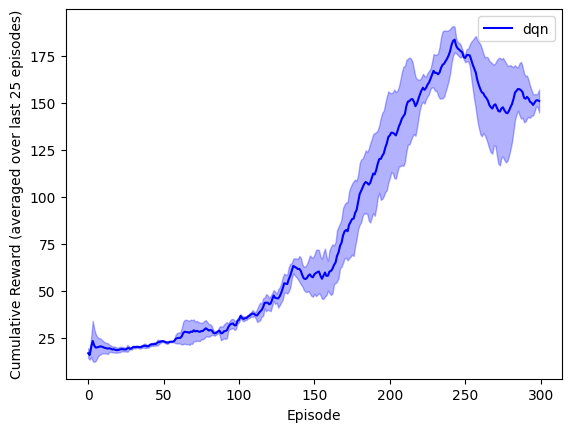

In [8]:
# Plot mean curve and (mean-std, mean+std) curve with some transparency
def plot_arrays(vars, color, label):
    mean = np.mean(vars, axis=0)
    std = np.std(vars, axis=0)
    plt.plot(range(len(mean)), mean, color=color, label=label)
    plt.fill_between(range(len(mean)), np.maximum(mean-std, 0),
                     np.minimum(mean+std, 200), color=color, alpha=0.3)


if __name__ == "__main__":
    # Train for different seeds
    curves = []
    for seed in SEEDS:
        curves += [train(seed)]

    # Plot the curve for the given seeds
    plot_arrays(curves, 'b', 'dqn')
    plt.legend(loc='best')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward (averaged over last 25 episodes)')
    plt.show()

## Part 3: DQN

### a)
Modify and run the code for CartPole DQN to produce a graph where the
y-axis is the running average of 25 episodes for the cumulative rewards
obtained at each episode and the x-axis is the number of episodes up
to a minimum of 300 episodes. **The graph should contain 3 curves
corresponding to updating the target network every 1, 10 (default) and 30
training step(s).** To reduce stochasticity in the results, report curves
that are the average of at least 3 runs of the given code (with different
random seeds). Based on the results, **explain the impact of the target
network and relate the target network to value iteration** (worth 20%).


Training with target update frequency of 1
Seed=1
Training:


R25(98.2): 100%|██████████| 300/300 [00:21<00:00, 13.82it/s]  


Training finished!
Seed=2
Training:


R25(83.28): 100%|██████████| 300/300 [00:22<00:00, 13.22it/s] 


Training finished!
Seed=3
Training:


R25(183.68): 100%|██████████| 300/300 [00:26<00:00, 11.23it/s]


Training finished!

Training with target update frequency of 10
Seed=1
Training:


R25(156.72): 100%|██████████| 300/300 [00:34<00:00,  8.79it/s] 


Training finished!
Seed=2
Training:


R25(142.56): 100%|██████████| 300/300 [00:34<00:00,  8.76it/s] 


Training finished!
Seed=3
Training:


R25(153.84): 100%|██████████| 300/300 [00:31<00:00,  9.54it/s]


Training finished!

Training with target update frequency of 30
Seed=1
Training:


R25(166.12): 100%|██████████| 300/300 [00:23<00:00, 12.79it/s]


Training finished!
Seed=2
Training:


R25(130.4): 100%|██████████| 300/300 [00:20<00:00, 14.54it/s]  


Training finished!
Seed=3
Training:


R25(179.88): 100%|██████████| 300/300 [00:28<00:00, 10.49it/s]

Training finished!


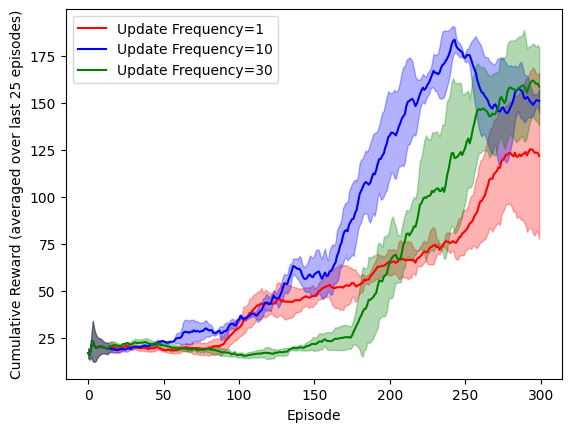

In [9]:
if __name__ == "__main__":
    default = TARGET_UPDATE_FREQ
    for freq, color in zip([1, 10, 30], ['r', 'b', 'g']):
        TARGET_UPDATE_FREQ = freq
        print(f"\nTraining with target update frequency of {freq}")
        curves = []
        for seed in SEEDS:
            curves += [train(seed)]
        plot_arrays(curves, color, f'Update Frequency={freq}')
    TARGET_UPDATE_FREQ = default

    plt.legend(loc='best')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward (averaged over last 25 episodes)')
    plt.show()

#### Impact of the Target Network

1. **Update Frequency = 1 (Red Curve)**:
   - The red curve starts slower and shows the least performance in the initial episodes.
   - It takes longer to converge compared to the other update frequencies.
   - Eventually, it converges to a lower cumulative reward compared to the others, indicating less optimal performance.

2. **Update Frequency = 10 (Blue Curve)**:
   - The blue curve shows a faster increase in cumulative reward compared to the red curve.
   - It achieves the highest cumulative reward earlier in the training process.
   - This frequency appears to balance between frequent and infrequent updates, leading to a more stable and higher performance.

3. **Update Frequency = 30 (Green Curve)**:
   - The green curve initially lags behind the blue curve but catches up and achieves a comparable cumulative reward.
   - There is a greater variance in performance (shaded region) indicating more instability during training.
   - The green curve shows that with infrequent updates, the learning process can still converge to a high reward but might be more unstable initially.

In general, updating the target network too frequently might not allow the policy to explore enough, while updating too infrequently can lead to instability and slower learning. A moderate update frequency (like 10) often provides a good balance for efficient learning.

#### Relation to Value Iteration

  - In value iteration, the value function is updated iteratively until it converges to the optimal value function.
  - Similarly, in DQN, the target network provides stable target values for the Q-value updates, aiding convergence to the optimal Q-values.
  - Both methods rely on the Bellman equation for updates. In value iteration, it directly updates the value function. In DQN, the target network uses the Bellman equation to provide stable target values for updating the Q-value function.

### b)
Modify and run the code for CartPole DQN to produce a graph where the
y-axis is the running average of 25 episodes for the cumulative rewards
obtained at each episode and the x-axis is the number of episodes up
to a minimum of 300 episodes. **The graph should contain 3 curves
corresponding to sampling mini-batches of 1, 10 (default) and 30
experience(s) from the replay buffer.** To reduce stochasticity in the results,
report curves that are the average of at least 3 runs of the given code (with
different random seeds). Based on the results, **explain the impact of the
replay buffer and explain the difference between using the replay buffer
and exact gradient descent** (worth 20%).


Training with replay mini-batch size of 1
Seed=1
Training:


R25(14.8571):   0%|          | 0/300 [00:00<?, ?it/s]

R25(52.76): 100%|██████████| 300/300 [00:12<00:00, 24.72it/s] 


Training finished!
Seed=2
Training:


R25(44.84): 100%|██████████| 300/300 [00:10<00:00, 28.17it/s]  


Training finished!
Seed=3
Training:


R25(31.04): 100%|██████████| 300/300 [00:10<00:00, 29.60it/s]  


Training finished!

Training with replay mini-batch size of 10
Seed=1
Training:


R25(156.72): 100%|██████████| 300/300 [00:36<00:00,  8.19it/s] 


Training finished!
Seed=2
Training:


R25(142.56): 100%|██████████| 300/300 [00:37<00:00,  8.05it/s]


Training finished!
Seed=3
Training:


R25(153.84): 100%|██████████| 300/300 [00:30<00:00,  9.93it/s]


Training finished!

Training with replay mini-batch size of 30
Seed=1
Training:


R25(144.56): 100%|██████████| 300/300 [00:51<00:00,  5.86it/s]


Training finished!
Seed=2
Training:


R25(159.12): 100%|██████████| 300/300 [00:46<00:00,  6.50it/s]


Training finished!
Seed=3
Training:


R25(185.84): 100%|██████████| 300/300 [00:48<00:00,  6.23it/s] 

Training finished!


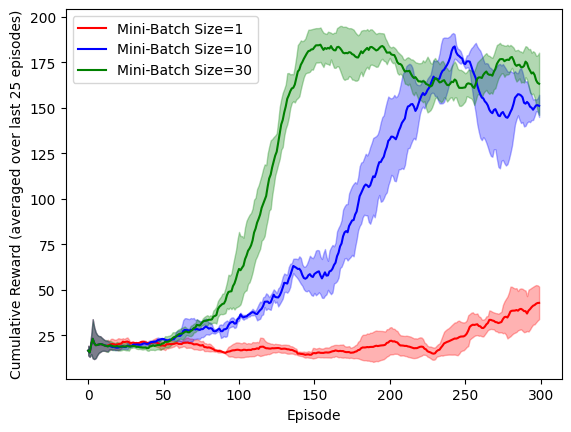

In [10]:
if __name__ == "__main__":
    default = MINIBATCH_SIZE
    for size, color in zip([1, 10, 30], ['r', 'b', 'g']):
        MINIBATCH_SIZE = size
        print(f"\nTraining with replay mini-batch size of {size}")
        curves = []
        for seed in SEEDS:
            curves += [train(seed)]
        plot_arrays(curves, color, f'Mini-Batch Size={size}')
    MINIBATCH_SIZE = default

    plt.legend(loc='best')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward (averaged over last 25 episodes)')
    plt.show()

#### Impact of Batch Size on Performance

1. **Mini-Batch Size = 1 (Red Curve)**:
   - The red curve shows the slowest learning progression and achieves the lowest cumulative reward over time.
   - There is less stability and more variance in performance, as indicated by the wide shaded area.
   - Smaller mini-batch sizes provide less diversity in the training data for each update, leading to slower convergence.

2. **Mini-Batch Size = 10 (Blue Curve)**:
   - The blue curve shows a faster increase in cumulative reward compared to the red curve and achieves higher rewards.
   - The performance is still unstable, as indicated by more fluctuations.
   - This size offers an improvement in learning process.

3. **Mini-Batch Size = 30 (Green Curve)**:
   - The green curve demonstrates the fastest learning progression and reaches the highest cumulative reward relatively early in the training process.
   - There is some variance in performance, but overall, it shows stability and high performance.
   - Larger mini-batch sizes provide more diverse training samples, leading to better generalization and faster convergence. However, they also require more computational resources.

In conclusion, A larger batch size provides more stable and accurate gradient estimates, leading to better performance.

#### Difference Between Using the Replay Buffer and Exact Gradient Descent

1. **Replay Buffer**:
   - **Stochastic Gradient Descent**: DQN uses a replay buffer to sample mini-batches of experiences and perform stochastic gradient descent (SGD). This approach helps in stabilizing the updates by providing uncorrelated and diverse samples.
   - **Efficiency**: The replay buffer allows for efficient use of past experiences, improving sample efficiency and allowing the agent to learn from a broader set of data.

2. **Exact Gradient Descent**:
   - **Full Batch Updates**: Exact gradient descent would require using all available data to compute the gradient and update the network. This approach is computationally expensive and impractical in an online reinforcement learning setting where data is continuously generated.
   - **High Correlation**: Without a replay buffer, using experiences directly as they are generated leads to high correlations between updates, which destabilizes the learning process.
   - **Efficiency and Stability**: Exact gradient descent is less efficient in terms of sample usage and often leads to unstable updates due to the high correlation between consecutive experiences.